In [1]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, BertModel, BertForSequenceClassification, BertTokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Concatenate, GlobalAveragePooling1D
import torch
from sentence_transformers import SentenceTransformer, util
from models.tarnet import TARNetTrainer
from sklearn.model_selection import train_test_split
from torchsummary import summary
import tensorflow as tf
import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from time import time
import gc

# S-Learner

## Offense module

In [2]:
#roBERTa model
off_MOD = f"cardiffnlp/twitter-roberta-base-offensive"

#Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(off_MOD)
off_class_mod = AutoModelForSequenceClassification.from_pretrained(off_MOD)
off_class_mod.eval();

In [3]:
def Compute_Offense(tokenizer,off_mod,texts,batch_size):
  # Split texts into batches
  batches = [texts[i:i + batch_size] for i in range(0, len(texts), batch_size)]
  batch_out_1 = []

  with torch.no_grad():
      for batch in batches:
          encoded_inputs = tokenizer(batch,padding=True,return_tensors='pt')

          # Compute the outputs of the module as a numpy array.
          emb_1 = off_mod(**encoded_inputs)[0]
          scores_1 = []
          for i in range(emb_1.shape[0]):
                scores_1.append(softmax(emb_1[i].detach().numpy()))
          scores_1 = np.array(scores_1)
          batch_out_1.append(scores_1)

          encoded_inputs = None
          emb_1 = None
          gc.collect() 
    
  outs_off = np.concatenate(batch_out_1,axis=0)  

  return outs_off

### Loading the texts and labels of the training data

In [4]:
def get_texts(df):
    np_array = df["text"].to_numpy()
    texts = []
    for i in range(len(np_array)):
        texts.append(np_array[i])
    return texts

In [5]:
def truncate(texts,max_length):
    for i in range(len(texts)):
      if len(texts[i]) > max_length:
        texts[i] = texts[i][:max_length]
    return texts

In [6]:
max_length = 150

In [7]:
df_train = pd.read_csv('data/frenk_train.tsv',sep='\t')
frenk_train = get_texts(df_train)
frenk_train = truncate(frenk_train,max_length)
frenk_label_train = df_train["label"].to_numpy()

In [8]:
df_train = pd.read_csv('data/try_train.tsv',sep='\t')
try_train = get_texts(df_train)
try_train = truncate(try_train,max_length)
try_label_train = df_train['label'].to_numpy()

### Computing the offensivity of the training data (If it's already saved you can skip this step)

In [ ]:
batch_size = 32

In [ ]:
t = time()
outs_off = Compute_Offense(tokenizer,off_class_mod,frenk_train,batch_size)
print("Elapsed time:",time()-t)

class_off = []
for i in range(len(frenk_train)):
    class_off.append(outs_off[i].argmax()) 

np.save('outs/frenk/class_off_train_outs.npy',class_off)

In [11]:
t = time()
outs_off = Compute_Offense(tokenizer,off_class_mod,try_train,batch_size)
print("Elapsed time:",time()-t)

class_off = []
for i in range(len(try_train)):
    class_off.append(outs_off[i].argmax())   
    
np.save('outs/try/class_off_train_outs.npy',class_off)

Elapsed time: 553.1745927333832


## Training inputs

### Embeddings and binary offense

In [9]:
frenk_sent_train = np.load('outs/frenk/sent_train_outs.npy')
frenk_c_off_train = np.load('outs/frenk/class_off_train_outs.npy')
frenk_gen_train = np.load('outs/frenk/gen_train_outs.npy')

In [10]:
try_sent_train = np.load('outs/try/sent_train_outs.npy')
try_c_off_train = np.load('outs/try/class_off_train_outs.npy')
try_gen_train = np.load('outs/try/gen_train_outs.npy')

In [11]:
sent_train = np.concatenate([frenk_sent_train,try_sent_train],axis=0)
c_off_train = np.concatenate([frenk_c_off_train,try_c_off_train],axis=0)
gen_train = np.concatenate([frenk_gen_train,try_gen_train],axis=0)

In [12]:
c_off_train = c_off_train.reshape(len(c_off_train),1)
conc_train = np.concatenate([sent_train,gen_train,c_off_train],axis=1)

### Labels

In [13]:
label_train = np.concatenate([frenk_label_train,try_label_train])

In [14]:
c_weights = compute_class_weight('balanced', classes=np.unique(label_train), y=label_train)
c_weights = {0:c_weights[0], 1:c_weights[1]}

### Training and Validation splits

In [16]:
conc_train,conc_val,label_train,label_val = train_test_split(conc_train,label_train,test_size=0.1,random_state=42)

## Factual inputs

In [18]:
sent_fact_outs = np.load('outs/counterfactuals/sent_fact_outs.npy')
factual_off = np.load('outs/counterfactuals/factual_off.npy')
gen_fact_outs = np.load('outs/counterfactuals/gen_fact_outs.npy')

In [19]:
factual_off = factual_off.reshape(len(factual_off),1)
conc_fact = np.concatenate([sent_fact_outs,gen_fact_outs,factual_off],axis=1)

## Factual labels

In [20]:
df_factuals = pd.read_csv('data/factuals.tsv',sep='\t')
labels_factuals = df_factuals["label"].to_numpy()

## Counterfactual inputs (with offense intervention at the feature level)

In [21]:
# Offense intervention
cf_off = []
for i in range(len(factual_off)):
    if factual_off[i][0] == 0:
        cf_off.append([1])
    else:
        cf_off.append([0])
cf_off = np.array(cf_off)

In [22]:
conc_cf = np.concatenate([sent_fact_outs,gen_fact_outs,cf_off],axis=1)

## PEACE model

In [23]:
n_runs = 20

In [24]:
best_f1_val = 0
best_model = None
for i in range(n_runs):
    hate_model = Sequential([
          Flatten(),
          Dense(128, activation='relu'),
          Dense(128, activation='relu'),
          Dense(1, activation='sigmoid')
      ])
    hate_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    hate_model.fit(conc_train, label_train, class_weight=c_weights, epochs=10, batch_size=32)
    
    #Selecting the model with best f1 score in the validation set
    f_hate = np.squeeze(hate_model.predict(conc_val))
    preds = (f_hate > 0.5).astype(int)
    f1_val = metrics.f1_score(preds,label_val,zero_division=1)
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_model = hate_model

Epoch 1/10
517/517 [==============================] - 2s 2ms/step - loss: 0.5525 - accuracy: 0.7008
Epoch 2/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5206 - accuracy: 0.7233
Epoch 3/10
517/517 [==============================] - 1s 2ms/step - loss: 0.5101 - accuracy: 0.7248
Epoch 4/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4947 - accuracy: 0.7315
Epoch 5/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4817 - accuracy: 0.7451
Epoch 6/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4708 - accuracy: 0.7449
Epoch 7/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4598 - accuracy: 0.7578
Epoch 8/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4413 - accuracy: 0.7648
Epoch 9/10
517/517 [==============================] - 1s 2ms/step - loss: 0.4291 - accuracy: 0.7755
Epoch 10/10
58/58 [==============================] - 0s 1ms/step
Epoch 1/10
517/517 [===============

In [25]:
f_hate = np.squeeze(best_model.predict(conc_fact))
cf_hate = np.squeeze(best_model.predict(conc_cf))

96/96 [==============================] - 0s 916us/step


## Classification metrics of the factuals

In [26]:
preds = (f_hate > 0.5).astype(int)
acc_test = metrics.accuracy_score(preds,labels_factuals)
f1_test = metrics.f1_score(preds,labels_factuals,zero_division=1)

print("Accuracy:",acc_test)
print("F1 score:",f1_test)

Accuracy: 0.7055937193326791
F1 score: 0.647335423197492


## Computing the ITE

In [27]:
ITE_peace = []
for i in range(len(f_hate)):
    if factual_off[i][0]:
        ITE_peace.append(f_hate[i] - cf_hate[i])
    else:
        ITE_peace.append(cf_hate[i] - f_hate[i])

# ATE

In [28]:
print("ATE:",np.mean(ITE_peace))

ATE: 0.04321015


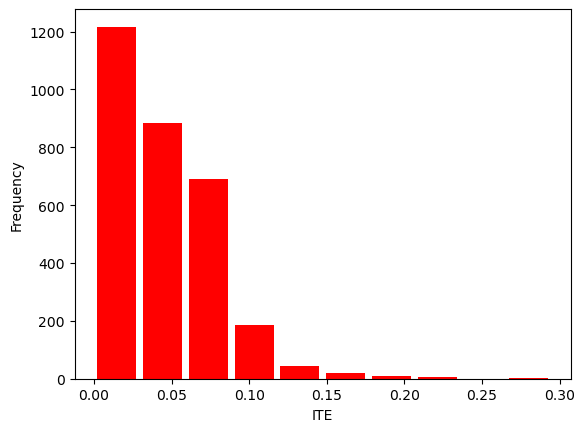

In [56]:
#Histogram of ITE
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(x=ITE_peace, color='red',rwidth=0.85)
ax.set_xlabel('ITE')
ax.set_ylabel('Frequency')
plt.show()

In [47]:
print("Max. ITE:",np.max(ITE_peace))
print("Min. ITE:",np.min(ITE_peace))

Max. ITE: 0.29485983
Min. ITE: 8.479255e-12


# TARNet

## Inputs and labels of TARNet and DragonNET

In [31]:
X_train = conc_train[:,0:-1]
T_train = conc_train[:,-1]
Y_train = label_train

X_val = conc_val[:,0:-1]
T_val = conc_val[:,-1]
Y_val = label_val

X_test = np.concatenate([sent_fact_outs,gen_fact_outs],axis=1)
T_test = np.squeeze(factual_off)
Y_test = labels_factuals

## Training the model

In [32]:
n_runs = 20

In [33]:
best_f1_val = 0
best_model = None
for i in range(n_runs):
    model = TARNetTrainer(X_train, T_train, Y_train)
    t = time()
    model.train()
    print("Elapsed time:",time()-t)
    
    #Selecting the model with best f1 score
    probs = model.predict(X_val)
    f_hate = np.array([x[0] if t == 0 else x[1] for x, t in zip(probs, T_val)])
    preds = (f_hate > 0.5).astype(int)
    f1_val = metrics.f1_score(preds,Y_val,zero_division=1)
    print(f1_val)
    if f1_val > best_f1_val:
        best_f1_val = f1_val
        best_model = model

Elapsed time: 178.80783772468567
0.5856031128404668
Elapsed time: 187.90226006507874
0.5705882352941176
Elapsed time: 158.60697531700134
0.6005560704355885
Elapsed time: 152.41577124595642
0.48539325842696635
Elapsed time: 171.18013167381287
0.5761078998073217
Elapsed time: 204.94431567192078
0.576735092864125
Elapsed time: 191.36433482170105
0.5899419729206963
Elapsed time: 177.18637323379517
0.6086142322097378
Elapsed time: 169.81835865974426
0.5478348439073515
Elapsed time: 154.87337446212769
0.5855018587360595
Elapsed time: 236.03051924705505
0.5645472061657033
Elapsed time: 176.3423933982849
0.5753424657534246
Elapsed time: 211.3288013935089
0.5827937095282146
Elapsed time: 193.28947615623474
0.5914972273567467
Elapsed time: 171.8769495487213
0.5760000000000001
Elapsed time: 176.75407457351685
0.554639175257732
Elapsed time: 179.59723377227783
0.5669291338582677
Elapsed time: 166.80043196678162
0.5673624288425047
Elapsed time: 189.24833250045776
0.5566801619433198
Elapsed time: 15

## Obtaining the hate of the factuals

In [35]:
probs = best_model.predict(X_test)
f_hate = np.array([x[0] if t == 0 else x[1] for x, t in zip(probs, T_test)])

## Classification metrics of the factuals

In [36]:
preds = (f_hate > 0.5).astype(int)
acc_test = metrics.accuracy_score(preds,Y_test)
f1_test = metrics.f1_score(preds,Y_test,zero_division=1)

print("Accuracy:",acc_test)
print("F1 score:",f1_test)

Accuracy: 0.7638207392868825
F1 score: 0.608884073672806


## Computing the ITE

In [37]:
def predict_model_nn(model, X_test, T_test):

    pred = model.predict(X_test)
    final_pred = [x[0] if t == 0 else x[1] for x, t in zip(pred, T_test)]
    ite_pred = [x[1] - x[0] for x in pred]
    
    hate_bin = []
    for i in range(len(pred)):
        hate_t_0 = 1 if pred[i][0] > 0.5 else 0
        hate_t_1 = 1 if pred[i][1] > 0.5 else 0
        hate_bin.append([hate_t_0,hate_t_1])
    ite_pred_hate_bin = [x[1] - x[0] for x in hate_bin]

    return final_pred, ite_pred, pred[:, 2], ite_pred_hate_bin

In [38]:
_, ite, _,ite_hate_bin = predict_model_nn(model, X_test, T_test)

## ATE

In [50]:
print("ATE:",np.mean(ite))

ATE: 0.096342124


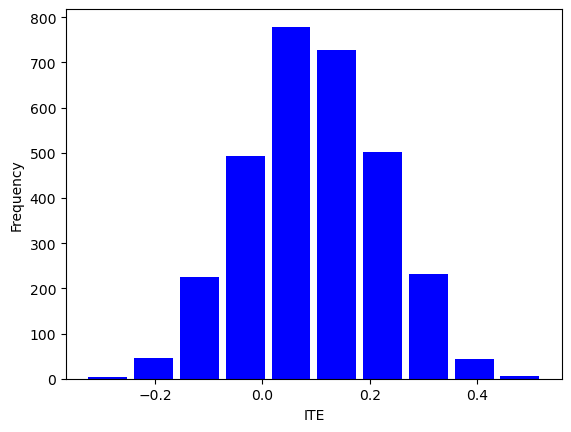

In [54]:
#Histogram of ITE
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(x=ite, color='blue',rwidth=0.85)
ax.set_xlabel('ITE')
ax.set_ylabel('Frequency')
plt.show()

In [40]:
np.save('outs/backdoor/ITE_tarnet.npy',np.array(ite))

# ITE backdoor vs ITE counterfactuals

In [2]:
ITE_back = np.load('outs/backdoor/ITE_tarnet.npy')

## ITE tarnet vs ITE PEACE

In [3]:
ITE_cf_all = np.load('outs/counterfactuals/ITE_peace.npy')

In [4]:
# For each factual we select the counterfactuals ITE that is more similar to the ITE backdoor one
n_cf = 5
ITE_cf = []
i = 0
for j in range(0,len(ITE_cf_all),n_cf):
    best_diff = np.inf
    best_ite = 0
    for k in range(n_cf):
        diff = np.abs(ITE_cf_all[j+k] - ITE_back[i])
        if diff < best_diff:
            best_diff = diff
            best_ite = ITE_cf_all[j+k]
    ITE_cf.append(best_ite)
    i+=1
ITE_cf = np.array(ITE_cf)

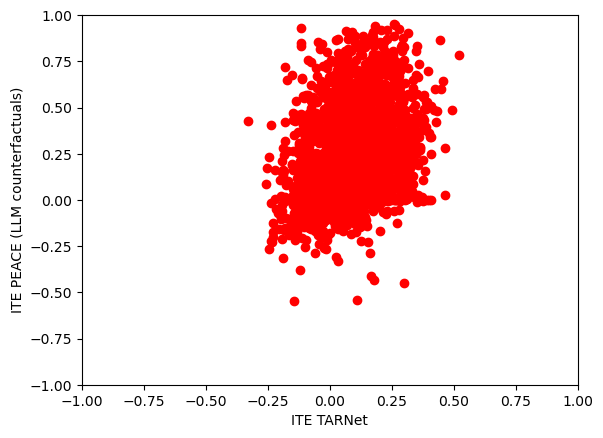

In [5]:
fig, ax = plt.subplots()
ax.scatter(ITE_back, ITE_cf, color='red')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('ITE TARNet')
ax.set_ylabel('ITE PEACE (LLM counterfactuals)')
plt.show()

## ITE tarnet vs ITE HateBERT

In [105]:
ITE_cf_all = np.load('outs/counterfactuals/ITE_hatebert.npy')

In [106]:
# For each factual we select the counterfactuals ITE that is more similar to the ITE backdoor one
n_cf = 5
ITE_cf = []
i = 0
for j in range(0,len(ITE_cf_all),n_cf):
    best_diff = np.inf
    best_ite = 0
    for k in range(n_cf):
        diff = np.abs(ITE_cf_all[j+k] - ITE_back[i])
        if diff < best_diff:
            best_diff = diff
            best_ite = ITE_cf_all[j+k]
    ITE_cf.append(best_ite)
    i+=1
ITE_cf = np.array(ITE_cf)

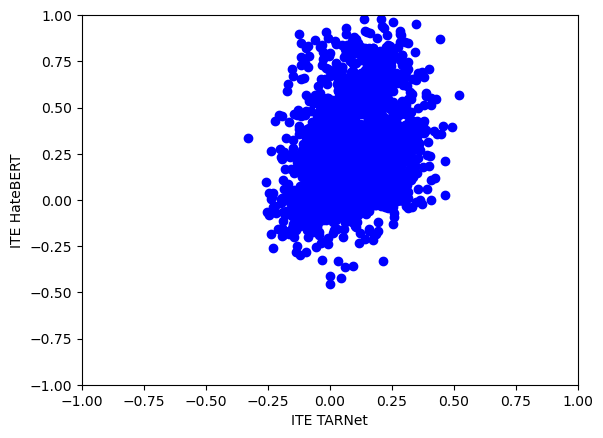

In [107]:
fig, ax = plt.subplots()
ax.scatter(ITE_back, ITE_cf, color='blue')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('ITE TARNet')
ax.set_ylabel('ITE HateBERT')
plt.show()

## ITE tarnet vs ITE Roberta Hate

In [108]:
ITE_cf_all = np.load('outs/counterfactuals/ITE_roberta_hate.npy')

In [109]:
# For each factual we select the counterfactuals ITE that is more similar to the ITE backdoor one
n_cf = 5
ITE_cf = []
i = 0
for j in range(0,len(ITE_cf_all),n_cf):
    best_diff = np.inf
    best_ite = 0
    for k in range(n_cf):
        diff = np.abs(ITE_cf_all[j+k] - ITE_back[i])
        if diff < best_diff:
            best_diff = diff
            best_ite = ITE_cf_all[j+k]
    ITE_cf.append(best_ite)
    i+=1
ITE_cf = np.array(ITE_cf)

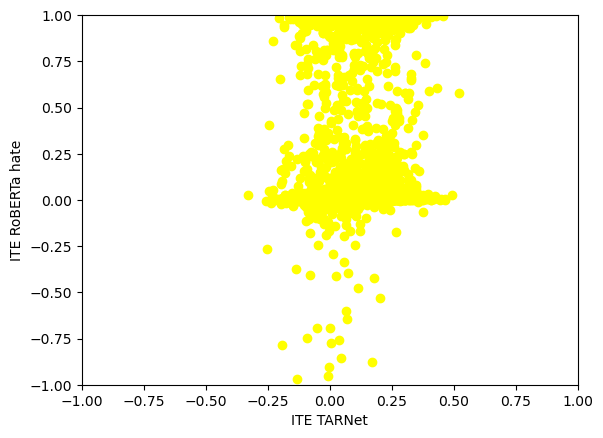

In [110]:
fig, ax = plt.subplots()
ax.scatter(ITE_back, ITE_cf, color='yellow')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('ITE TARNet')
ax.set_ylabel('ITE RoBERTa hate')
plt.show()

## ITE tarnet vs ITE Roberta Hate with our classifier

In [111]:
ITE_cf_all = np.load('outs/counterfactuals/ITE_roberta_hate_clf.npy')

In [112]:
# For each factual we select the counterfactuals ITE that is more similar to the ITE backdoor one
n_cf = 5
ITE_cf = []
i = 0
for j in range(0,len(ITE_cf_all),n_cf):
    best_diff = np.inf
    best_ite = 0
    for k in range(n_cf):
        diff = np.abs(ITE_cf_all[j+k] - ITE_back[i])
        if diff < best_diff:
            best_diff = diff
            best_ite = ITE_cf_all[j+k]
    ITE_cf.append(best_ite)
    i+=1
ITE_cf = np.array(ITE_cf)

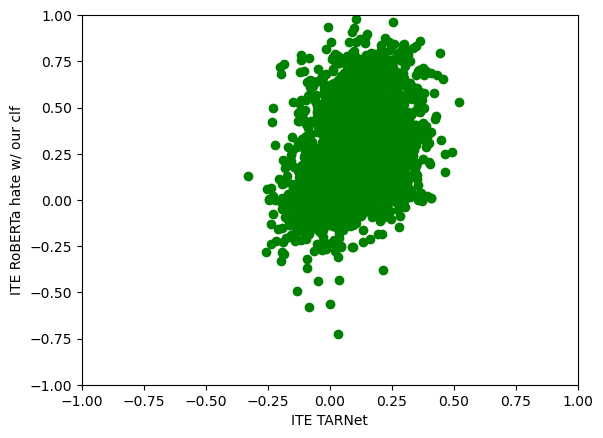

In [113]:
fig, ax = plt.subplots()
ax.scatter(ITE_back, ITE_cf, color='green')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('ITE TARNet')
ax.set_ylabel('ITE RoBERTa hate w/ our clf')
plt.show()